In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import warnings

#ignore Warnings

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


#Manipulasi data
import numpy as np
import pandas as pd

#Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# preprocess
from keras.preprocessing.image import ImageDataGenerator

#dl libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical


#specially for CNN
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dense,GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import tensorflow as tf
import random as rn

#soepecially for manipulating Zipped image and getting numpy arrays
import cv2
import os
from PIL import Image

In [3]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
%time
import warnings
warnings.filterwarnings("ignore")

width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = data['emotion']

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y)))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

CPU times: total: 0 ns
Wall time: 0 ns
Preprocessing Done
Number of Features: 48
Number of Labels: 35887
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


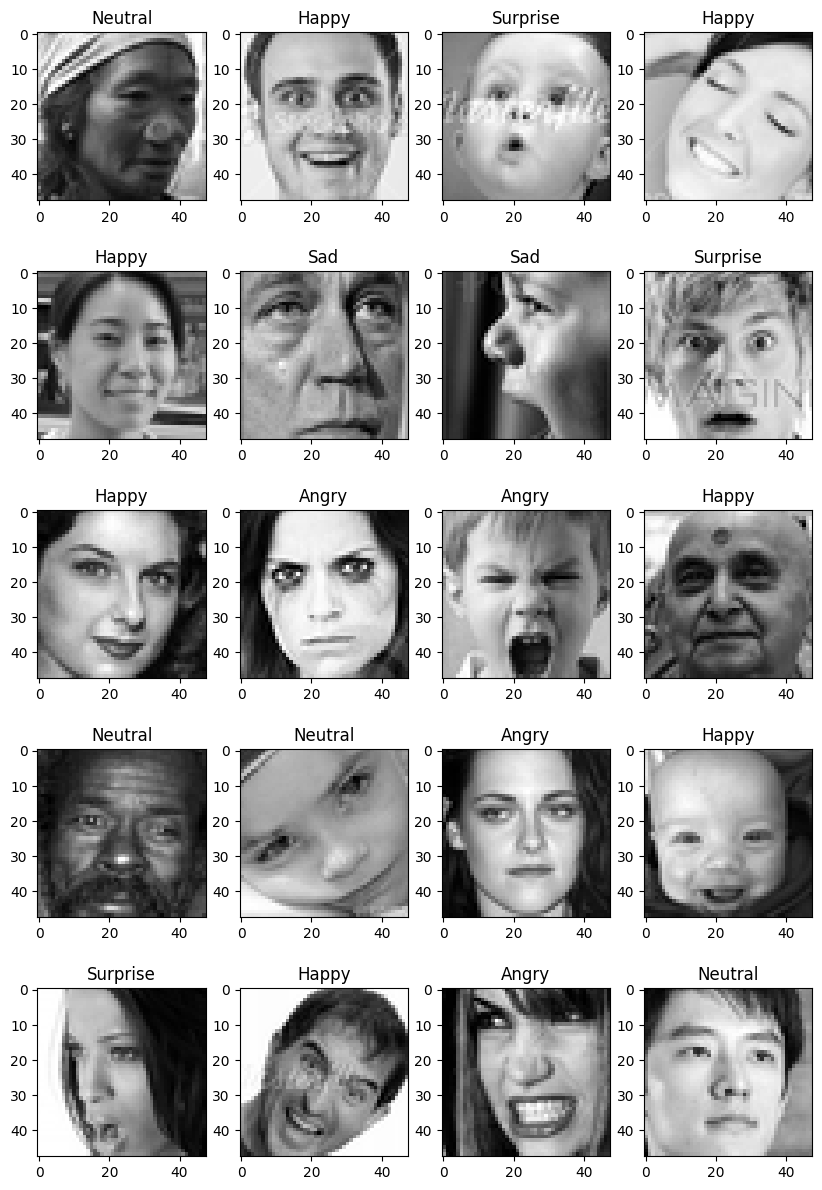

In [5]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

w=10
h=10
fig=plt.figure(figsize=(10, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    angka_random = rn.randint(1,len(X))
    plt.imshow(X[angka_random].reshape(48,48), cmap = 'gray')
    plt.title(labels[y[angka_random]])
plt.show()

In [6]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='LeakyReLU')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

In [7]:
# storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

Y = to_categorical(y,len(labels))
X = np.array(X)
X = X/255 #proses normalisasi

In [8]:
X_new = []
for i in range(len(X)):
    stacked_img = np.stack((X[i].reshape(48,48),)*3, axis=-1)
    X_new.append(stacked_img)


X_new = np.array(X_new)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_new, Y, test_size = 0.2)
print("Data Train Shape")
print("X_TRAIN : ", x_train.shape)
print("Y_TRAIN : ", y_train.shape)

print("Data Test Shape")
print("X_TRAIN : ", x_test.shape)
print("Y_TRAIN : ", y_test.shape)

Data Train Shape
X_TRAIN :  (28709, 48, 48, 3)
Y_TRAIN :  (28709, 7)
Data Test Shape
X_TRAIN :  (7178, 48, 48, 3)
Y_TRAIN :  (7178, 7)


In [10]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [17]:
batch_size= 64
epochs = 50


from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)


earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop, reduce_lr]

In [18]:
from keras.applications import MobileNetV2


base_model = MobileNetV2(weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer

# !---  changed here from softmax to relu
x = Dense(512, activation='softmax')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes


predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [19]:
%%time
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='AUC'), f1_score]
)

History = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=(x_test, y_test),
                              verbose=1)


Epoch 1/50
449/449 [==============================] - 139s 300ms/step - loss: 1.8561 - accuracy: 0.2608 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6521 - f1_score: 0.0000e+00 - val_loss: 1.8732 - val_accuracy: 0.2467 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.5978 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 129s 286ms/step - loss: 1.8117 - accuracy: 0.2621 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6607 - f1_score: 0.0000e+00 - val_loss: 1.8621 - val_accuracy: 0.1144 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.5882 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 130s 289ms/step - loss: 1.7971 - accuracy: 0.2643 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6660 - f1_score: 0.0000e+00 - val_loss: 1.8170 - val_accuracy: 0.2467 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6419 - val_f1_score: 0.0000e

In [20]:
df = pd.DataFrame(History.history)
df.to_excel("output0.xlsx")
#df.to_csv("output.csv")
df.head()

,loss,accuracy,precision,recall,AUC,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_AUC,val_f1_score,lr
0,1.856071,0.260754,0.0,0.0,0.652057,0.0,1.873155,0.246726,0.0,0.0,0.597762,0.0,0.001
1,1.811683,0.262113,0.0,0.0,0.660740,0.0,1.862053,0.114377,0.0,0.0,0.588217,0.0,0.001
2,1.797113,0.264273,0.0,0.0,0.666005,0.0,1.816984,0.246726,0.0,0.0,0.641927,0.0,0.001
3,1.794438,0.257794,0.0,0.0,0.664116,0.0,1.815459,0.246726,0.0,0.0,0.641927,0.0,0.001
4,1.752697,0.286217,0.0,0.0,0.692648,0.0,1.726702,0.299944,0.0,0.0,0.704693,0.0,0.001


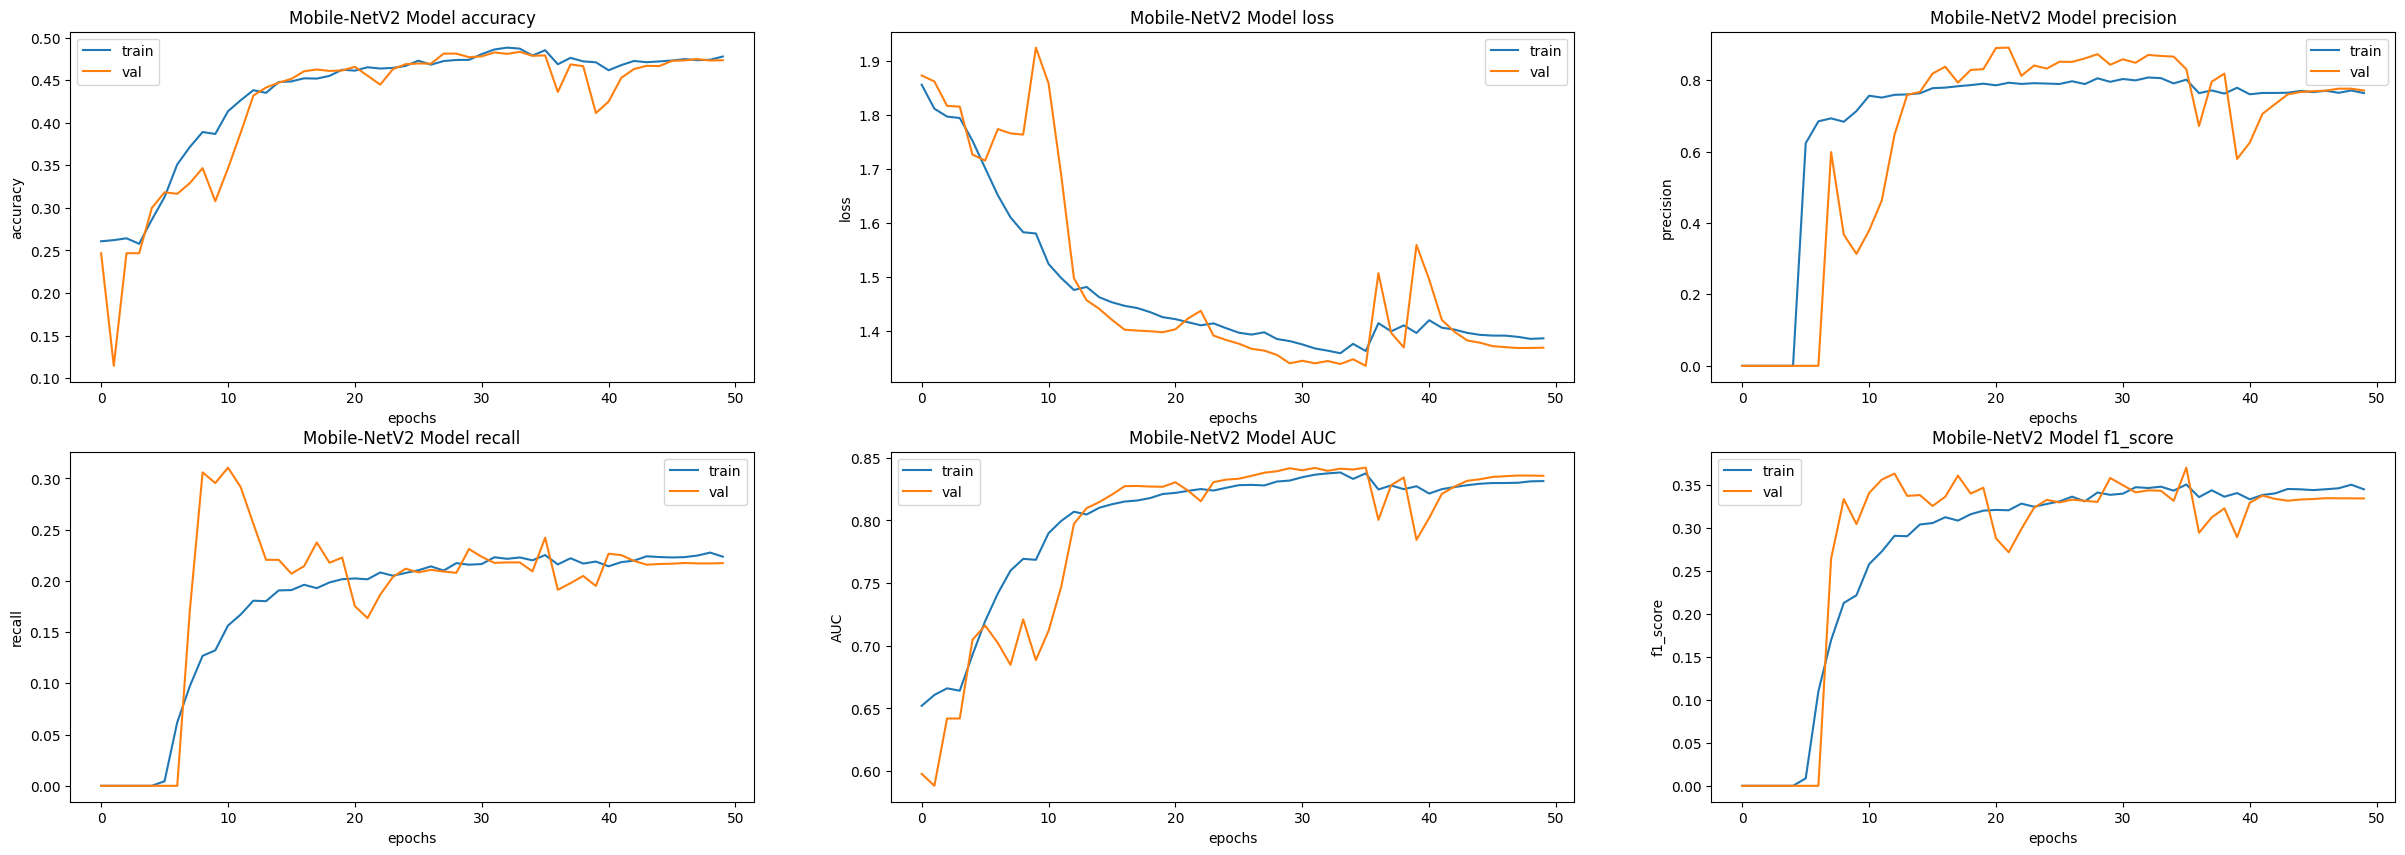

In [21]:
# Interpreting the Metrics
fig, ax = plt.subplots(2, 3, figsize=(30, 10))
ax = ax.ravel()

#for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score' ]):
    ax[i].plot(History.history[met])
    ax[i].plot(History.history['val_' + met])
    ax[i].set_title('Mobile-NetV2 Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-plot0.png")

In [22]:
truey=[]
predy=[]
x = x_test
y = y_test

yhat= model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

225/225 [==============================] - 8s 31ms/step
Predicted and true label values saved
Accuracy on test set :47.353023126219%


In [23]:
# Assuming you have already trained and compiled your model
model.save("MobileNetV2.h5")
